The goal of this notebook is to join together per captia economic data from https://apps.bea.gov/api/data/ and hospital data from https://data.medicare.gov based on economic location. The final product should be two SQL tables: "hospitals" and "income". There should be a complete a many to one join between the hospital and the income tables in order to explore how the economy of the area surronding the hospital impacts hospital metrics. I have never worked with either dataset prior to this.

In [24]:
import pandas as pd
import sqlite3
import requests
import json
from sodapy import Socrata
import keys # file of API keys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import scipy as sp


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

## Create hospital dataframe

In [2]:
# API call to the Data.Medicare.Gov Hospital General Information dataset
client = Socrata("data.medicare.gov", None)
results = client.get("xubh-q36u", limit = 10000)

# Convert to pandas DataFrame
hr_df = pd.DataFrame.from_records(results)
hr_df.describe()

# Because we are trying to map locations and values to hospitals
# we are going to worry about geography data for now
# the income data is done by county, we are going to use the 
# county and state data. State is in 'state' using two letter abbr. and the county name is in county_name. 
#

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,hospital_type,hospital_ownership,emergency_services,hospital_overall_rating,hospital_overall_rating_footnote,mortality_national_comparison,mortality_national_comparison_footnote,safety_of_care_national_comparison,safety_of_care_national_comparison_footnote,readmission_national_comparison,readmission_national_comparison_footnote,patient_experience_national_comparison,patient_experience_national_comparison_footnote,effectiveness_of_care_national_comparison,effectiveness_of_care_national_comparison_footnote,timeliness_of_care_national_comparison,timeliness_of_care_national_comparison_footnote,efficient_use_of_medical_imaging_national_comparison,efficient_use_of_medical_imaging_national_comparison_footnote,geocoded_column,:@computed_region_f3tr_pr43,:@computed_region_nwen_78xc,:@computed_region_csmy_5jwy,meets_criteria_for_meaningful_use_of_ehrs
count,5320,5320,5320,5320,5320,5320,5320,5320,5320,5320,5320,5320,1809,5320,1978,5320,2713,5320,1590,5320,1962,5320,2038,5320,1478,5320,2255,4920,4917,4917,4865,3764
unique,5320,5153,5292,3052,56,4682,1569,5301,5,11,2,6,6,4,5,4,5,4,5,4,4,4,4,4,4,4,4,4907,2361,2361,51,1
top,210024,MEMORIAL HOSPITAL,100 HOSPITAL DRIVE,CHICAGO,TX,77030,LOS ANGELES,(414) 585-1374,Acute Care Hospitals,Voluntary non-profit - Private,Yes,Not Available,16,Same as the national average,5,Not Available,5,Not Available,19,Not Available,16,Same as the national average,5,Not Available,19,Same as the national average,5,"{'type': 'Point', 'coordinates': [-81.607239, ...",1195,1195,23,Y
freq,1,12,8,33,449,6,90,2,3263,2228,4498,1749,983,2616,705,2711,1006,1589,695,1962,1196,2910,1014,1478,695,2339,1004,2,87,87,425,3764


## Create per capita income dataframe

In [3]:
# API Call to get average income per capita per county from SEA data
key = keys.sea_api_key
econ_addr = "https://apps.bea.gov/api/data/"

parameters = {
    "UserID" : key,
    "DATASETNAME" : 'Regional',
    "RESULTFORMAT" : 'JSON',
    "METHOD" : "GETDATA",
    'GEOFIPS': 'COUNTY',
    'TABLENAME': 'CAINC1',
    'YEAR': '2018',
    'LINECODE': '3'
}

response = requests.get(econ_addr, parameters)
inc_json = response.json()

# print(inc_json.keys()
# out: ['BEAAPI']
# print(inc_json['BEAAPI'].keys())
# out: ['Request', 'Results'])
# print(inc_json['BEAAPI']['Results'].keys()
# out: ['Statistic', 'UnitOfMeasure', 'PublicTable', 'UTCProductionTime', 'NoteRef', 'Dimensions', 'Data', 'Notes']

# once down to the flat data layer, then turn into a df
inc_data = inc_json['BEAAPI']['Results']['Data']
inc_df = pd.DataFrame(inc_data)
inc_df.describe()

# Because we are trying to map locations and values to hospitals
# we are going to worry about geography data for now
# GeoFips unique identifier for each region, is what we should map to the hospitals
# GeoName is string of "county name, state", each is unique
# NoteREf: notes about the data. The notes have to do with how county definitons have changed
# over time, but not relevant given we are working with modern hospital data that should 
# be encodded using modern county definitions

,Code,GeoFips,GeoName,TimePeriod,CL_UNIT,UNIT_MULT,DataValue,NoteRef
count,3138,3138,3138,3138,3138,3138,3138,80
unique,1,3138,3138,1,1,1,2967,2
top,CAINC1-3,48287,"Harvey, KS",2018,Dollars,0,(NA),*
freq,3138,1,1,3138,3138,3138,25,55


In [4]:
# hospital data has the location of each available at the state
# and county level in individual columns, but for the income data,
# the location is designated by a single string that has both the 
# county and the state. So the first step is to split the data up into indv. cols

# using right split because the state comes after the last comma
county_state_split = inc_df.GeoName.str.rsplit(",", n=1, expand=True)
inc_df['county_name'] = county_state_split[0]
inc_df['state'] = county_state_split[1]

# county_name clean up
# need to make the county name all upper to match the econ data
inc_df['county_name'] = inc_df['county_name'].str.upper().str.strip()
# The hospital data lists the county of hospitals in independent cities as:
# X CITY (e.g. ALEXANDRIA (INDEPENDENT CITY))
# where the SEA data lists as:
# "X (INDEPENDENT CITY)" (e.g. ALEXANDRIA (INDEPENDENT CITY))
# so convert those to the same string format
ind_city = (inc_df.county_name.str.contains("(INDEPENDENT CITY)", regex=False))
inc_df.loc[ind_city, 'county_name'] = inc_df.loc[ind_city, 'county_name'].str.replace("(INDEPENDENT CITY)", "CITY", regex=False)
# Remove the potentially redundant city added in if the independent city's name is X CITY
# e.g. Carson City
city_city = (inc_df.county_name.str.contains("CITY CITY", regex=False))
inc_df.loc[city_city, 'county_name'] = inc_df.loc[city_city, 'county_name'].str.replace("CITY ", "", n=1, regex=False)         
            
# Because there are some very small independent cities, they are often grouped with their
# nearby county for census purposes. The income data has the listed county for these places
# as "COUNTY + CITY" or "COUNTY, CITY + CITY" 
# So these need to be split out into individual cols, and for the every col
# After the first one, there needs to be a  "CITY" appended to match the 
# syntax the hospital data uses for independent cities
counties_split_out = inc_df.county_name.str.split(r" \+ |, ", expand = True)
counties_split_cols = ["county_name_{}".format(i) for i in range(counties_split_out.shape[1])]
inc_df[counties_split_cols] = counties_split_out
for col in counties_split_cols[1:]:
    inc_df[col] = inc_df[col] + " CITY"
# drop the county name col now that it has been split out
inc_df = inc_df.drop('county_name', 1)

# State name clean up
# need to remove the "*" that imply a note
inc_df['state'] = inc_df['state'].str.strip().str.replace("*", "")

# Make the data values numeric. The income data uses commas in the numbers
# that need to be removed
inc_df['DataValue'] = pd.to_numeric(inc_df['DataValue'].str.replace(",", ""), errors = 'coerce')

# drop the 25 cols that have nans. These are county designations that 
# have been used in the past, but not in 2018
inc_df = inc_df.dropna(subset = ['DataValue'])

In [5]:
# Manual modifications of the dataset

# This dataset does not have income data for US territories, so drop out the data
territories = ['VI', 'AS', 'MP', 'GU', 'PR']
hr_df = hr_df.loc[~hr_df.state.isin(territories)]

# Fixing typos in the hospital names.
# TODO: remove manual typo correction and use fuzzywuzzy
typos = {"NORTHWEST ARTIC BOROUGH" : "NORTHWEST ARCTIC BOROUGH", "NORTH SLOPE BOROUH" : "NORTH SLOPE BOROUGH",
         'JEFFRSON DAVIS' : 'JEFFERSON DAVIS','E. BATON ROUGE' : 'EAST BATON ROUGE', 'ST. JOHN BAPTIST': 
         'ST. JOHN THE BAPTIST', 'SITKA BOROUGH' : 'SITKA CITY AND BOROUGH', 'DONA ANA': 'DOÑA ANA',
         'LAKE OF  WOODS' : 'LAKE OF THE WOODS', 'YELLOW MEDCINE': 'YELLOW MEDICINE', 'SCOTT BLUFF': 'SCOTTS BLUFF',
         'NORTHUMBERLND' : 'NORTHUMBERLAND', 'LAPAZ': 'LA PAZ'}
for key in typos:
    hr_df.loc[hr_df.county_name == key, "county_name"] = typos[key]

In [6]:
# The first step is to find the exact matches between
# the state and county_name from the hospital df and the state and first county name column in the income df
# df is going to be the final hosptial df that we turn into a SQL table. The goal is it to be the same as
# the original table with a new col named GeoFips that corresponds to the correct GeoFip in the income 
# data table

# By doing an inner merge on, only going to get rows where both match togehter. By only selecting for hr_df cols
# and "GeoFips", df is just the hr_df where there is an exact match and the correct GeoFip for the hospital
df = pd.merge(hr_df, inc_df,  how='inner', left_on=['county_name','state'],
              right_on=[counties_split_cols[0],'state'], suffixes = [None, None])[list(hr_df) + ['GeoFips']]


# Remove the rows from hr_df that are now in df
hr_df = hr_df.loc[~hr_df.provider_id.isin(df.provider_id)]
print(hr_df.shape)
print(df.shape)
# We have perfect matches for all but 102 rows

(102, 32)
(5154, 33)


In [7]:
# need to check for matches on other counties_split_cols. Could do with inner merge like for the first call,
# but this is an alternate approach.
# First, left join the remaining unmatched rows of the hr_dr and the inc_df on state only
alt_matches_df = pd.merge(hr_df, inc_df,  how='left', on='state')
# Then find rows where hr_df matches any of the counties_split_cols
alt_matches_df = alt_matches_df.loc[alt_matches_df[counties_split_cols].isin(alt_matches_df.county_name).any(1)]
# Take those rows and append to the df with only the columns from the df
df = pd.concat([df, alt_matches_df[list(df)]])
hr_df = hr_df.loc[~hr_df.provider_id.isin(df.provider_id)]
# Update the hr_df with the missing
print(alt_matches_df.shape)
print(hr_df.shape)
print(df.shape)
# we added 19 more rows to the df, and have 83 unmatched

(19, 43)
(83, 32)
(5173, 33)


In [8]:
# DC just uses a different name for the county name between the two datasets, but both 
# consider it a single county, so just join by state only
# Get the DC GeoFip
dc_ind = inc_df.loc[inc_df.state == "DC", 'GeoFips'].values[0]
hr_df.loc[hr_df.state == "DC"]
# Assign to the hr_df DC rows
temp = hr_df.loc[hr_df.state == "DC"]
# append to the DF
df = pd.concat([df, temp])
df.loc[df.state == "DC", "GeoFips"] = dc_ind
hr_df = hr_df.loc[~hr_df.provider_id.isin(df.provider_id)]
print(temp.shape)
print(hr_df.shape)
print(df.shape)
# we added 9 more rows to the df, and have 74 unmatched

(9, 32)
(74, 32)
(5182, 33)


In [9]:
# Do the exact same thing as the original merge, but remove spaces and apostrophes from both county_name
# cols to enable an inexact match
# TODO: Do this step with fuzzywuzzy

hr_df['county_name_ns'] = hr_df.county_name.str.replace(" ", "", regex = False).str.replace("\'", "", regex = False)
inc_df[counties_split_cols[0] + "_na"] = inc_df[counties_split_cols[0]].str.replace(" ", "", regex = False).str.replace("\'", "", regex = False)
temp = pd.merge(hr_df, inc_df,  how='inner', left_on=['county_name_ns','state'],
              right_on=[counties_split_cols[0]  + "_na",'state'], suffixes = [None, None])[list(hr_df) + ['GeoFips']]

# remove the hr_df['county_name_ns'] to keep the columns the same as df before appending
temp = temp.drop('county_name_ns', 1)
df = pd.concat([df, temp])
hr_df = hr_df.loc[~hr_df.provider_id.isin(df.provider_id)]
print(temp.shape)
print(hr_df.shape)
print(df.shape)
# we added 55 more rows to the df, and have 19 unmatched

(55, 33)
(19, 33)
(5237, 33)


In [10]:
# Alaskan county names are written out more formally in the inc_data than in the hr_df
# So do a substring search to see if the shorter name from hr_df is in the longer name 
# of the inc_df
# TODO: Do this step with fuzzywuzzy

# Do a left merge on "state" for Alaska only. This creates a many to many match for each row in the hr_dr
# From there, can check if the hr_dr county name is a substring of the counties_split_cols[0]. Keep
# only the rows where it is true
temp = pd.merge(hr_df.loc[hr_df.state == "AK"], inc_df,  how='left', on='state')
# use a lambda function to see if col is substring of other col
temp = temp.loc[temp.apply(lambda x: x.county_name in x[counties_split_cols[0]], axis=1)]

df = pd.concat([df, temp[list(df)]])
hr_df = hr_df.loc[~hr_df.provider_id.isin(df.provider_id)]
print(temp.shape)
print(hr_df.shape)
print(df.shape)
# we added 19 more rows to the df, and have 0 unmatched

(19, 45)
(0, 33)
(5256, 33)


In [11]:
# create a dummy sql server in memory
conn = sqlite3.connect(":memory:")

In [12]:
# need to convert the geocode col which is a dictionary to a string for sql encoding
df['geocoded_column'] = df['geocoded_column'].astype(str)
df.to_sql('hospitals', con=conn)

# 'SELECT FirstName, LastName    -- list out: first names and surnames
#   FROM Patients
#   WHERE NOT EXISTS (    -- patients who do not meet criteria
#     SELECT * FROM Appointments -- get all columns from selection
#         WHERE Patients.PatientID = Appointments.PatientID -- appointment is for the patient
#           AND Appointments.AppointmentDate > DATEADD(year, -1, GETDATE())    -- appointments in last year
#           AND Appointments.AppointmentType = 1)    -- appointments that are AWVs'

In [13]:
inc_df.to_sql('income', con=conn)

In [22]:
# left join of hospitals and income on GeoFips filtered for hospitals
# where the average income is greater than 50k 
query = """SELECT * 
           FROM hospitals 
           LEFT JOIN income ON hospitals.GeoFips = income.GeoFips
           WHERE DATAVALUE > 75000"""

n_df = pd.read_sql_query(query, conn)

SpearmanrResult(correlation=0.07270728465834894, pvalue=1.4057046645957934e-05)

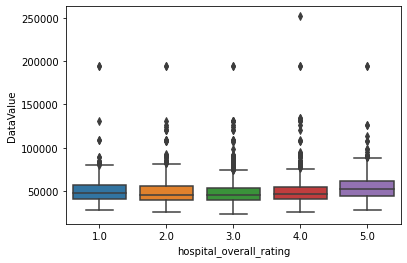

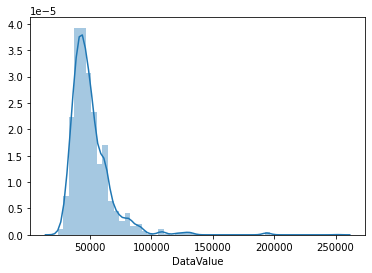

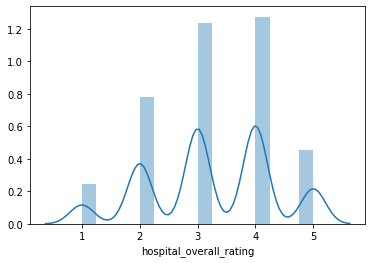

In [34]:
query = """SELECT * 
           FROM hospitals 
           LEFT JOIN income ON hospitals.GeoFips = income.GeoFips"""

n_df = pd.read_sql_query(query, conn)
n_df['hospital_overall_rating'] = pd.to_numeric(n_df['hospital_overall_rating'], errors= 'coerce')

n_df = n_df.dropna(subset = ['DataValue', 'hospital_overall_rating'])
sns.boxplot(y = 'DataValue', x = 'hospital_overall_rating', data = n_df)
plt.figure()
sns.distplot(n_df.DataValue)
plt.figure()
sns.distplot(n_df.hospital_overall_rating)

#There is a weak, but significant correlation between per capita income and overall hospital quality
sp.stats.spearmanr(n_df.DataValue, n_df.hospital_overall_rating)